In [31]:
from tensorflow import keras
from keras.layers import RNN
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

In [32]:
data = pd.read_csv('Sunspots.csv', parse_dates=True).drop(columns='Unnamed: 0')
data.head()
data.index = pd.DatetimeIndex(data['Date'])
data.drop(columns='Date',inplace=True)
data.columns=['Monthly_Mean_Sunspots']

week1 = data['Monthly_Mean_Sunspots']
week = week1.values

In [33]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(week.reshape(-1, 1))

In [34]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [35]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

2187 1078


In [36]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [37]:
from keras import Sequential
from keras.layers import Dense, LSTM

In [38]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Reshape trainX and testX
trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])

model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/3
2185/2185 - 17s - loss: 0.0120 - 17s/epoch - 8ms/step
Epoch 2/3
2185/2185 - 10s - loss: 0.0047 - 10s/epoch - 5ms/step
Epoch 3/3
2185/2185 - 12s - loss: 0.0047 - 12s/epoch - 5ms/step


In [39]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

34/34 [==============================] - 0s 3ms/step
Train Score: 27.09 RMSE
Test Score: 26.22 RMSE


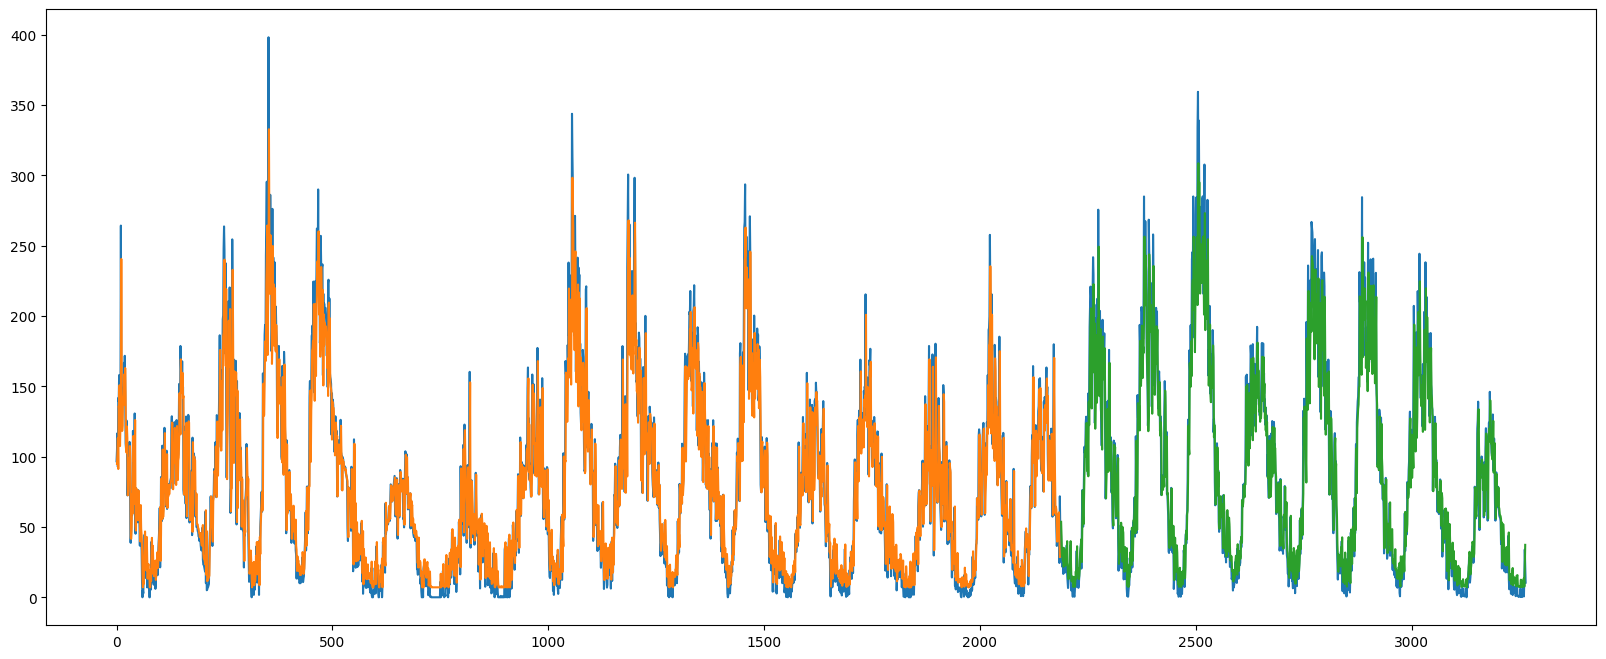

In [41]:
import matplotlib.pyplot as plt
# shift train predictions for 
plt.figure(figsize=(20, 8))
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [46]:
def bootstrap_residuals(residuals, window_size):

  bootstrapped_residuals = np.empty_like(residuals)
  for i in range(len(residuals)):
    # Select a random window of residuals.
    window = np.random.choice(residuals, window_size)

    # Replace the residual at the current index with the bootstrapped residual.
    bootstrapped_residuals[i] = window.mean()

  return bootstrapped_residuals

In [47]:
bootstrapped_residuals = bootstrap_residuals(residuals, window_size=100)


NameError: name 'residuals' is not defined